# Experiment

### Detailed Results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import math
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,5)

NUM_LOGS = 101876733
NUM_REGEX = 132
NUM_REP = 1
ns = [4, 8, 16, 32, 64, 96,  128, 192, 256, 512]

grams_fp = ['bigram']
grams_fp_header = ['bigram', 'trigram', 'fourgram',]

INDEX_HEADERS = ['NGram', 'Num_Indexed', 'Granularity', 'bitvector_index_building_time', 'bitvector_index_size', 'inverted_index_building_time', 'inverted_index_size_fit', 'inverted_index_size']

DIR_NAME = 'out_6_full'

GRANUS = [1, 8, 64, 192, 256, 512]

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
blare_times = pd.read_pickle('../blare_db_x_full.pkl')

In [4]:
# index building time
bt_df = pd.read_csv(f'{DIR_NAME}/index_building.csv', names=INDEX_HEADERS)  
bt_df['bitvector_index_size'] = bt_df['bitvector_index_size']/(1024 * 1024*1024)
bt_df['inverted_index_size'] = bt_df['inverted_index_size']/(1024 * 1024*1024)
bt_df['inverted_index_size_fit'] = bt_df['inverted_index_size_fit']/(1024 * 1024*1024)

In [6]:
def get_num_bits_masked(df, inverted):
    bit_masks = df['filter'].to_list()
    total_count = 0
    for m in bit_masks:
        if inverted:
            total_count += m.count('0')
        else:
            total_count += m.count('1')
    return total_count

In [7]:
fingerprint = 'bigram'

partial_df = bt_df[bt_df['NGram'] == fingerprint]
line_remains, ave_perc_line_rem, bits_masked = [], [], []
bit_bt_mean, bit_bt_se = [], []
inv_bt_mean, inv_bt_se = [], []
bt_size, inv_size = [], []
ft_mean, ft_se, total_matched = [], [], []
inv_mean, inv_se = [], []
blare_mean, blare_se = [], []
granus, num_idxs = [], []


for granu in GRANUS:
    for num_indexed in ns:
        # for a q-gram signature, with n qgrams indexed, and granualrity of index equals to granu
        granus.append(granu)
        num_idxs.append(num_indexed)
        
        curr_partial_df = partial_df[(partial_df['Num_Indexed'] == num_indexed) & (partial_df['Granularity'] == granu)]

        bit_bt_times = curr_partial_df['bitvector_index_building_time']
        inv_bt_times = curr_partial_df['inverted_index_building_time']

        bt_sizes = curr_partial_df['bitvector_index_size']
        inv_sizes = curr_partial_df['inverted_index_size_fit']

        bit_bt_mean.append(np.mean(bit_bt_times))
        inv_bt_mean.append(np.mean(inv_bt_times))

        bt_size.append(np.mean(bt_sizes))
        inv_size.append(np.mean(inv_sizes))

        bit_bt_se.append(np.std(bit_bt_times, ddof=1)/np.sqrt(len(bit_bt_times)))
        inv_bt_se.append(np.std(inv_bt_times, ddof=1)/np.sqrt(len(inv_bt_times)))

        filter_times = []
        invert_times = []
        dir_name = f'{DIR_NAME}/new_{fingerprint}_{num_indexed}_{granu}'

        # Summary csv
        f_name = os.path.join(dir_name, 'summary0.csv')
        if not os.path.isfile(f_name):
            line_remains.append(None)
            ave_perc_line_rem.append(None)
            bits_masked.append(None)
            total_matched.append(None)
            invert_times.append(None)
            ft_mean.append(None)
            ft_se.append(None)
            inv_mean.append(None)
            inv_se.append(None)
            continue

        sum_df = pd.read_csv(f_name, sep='\t', dtype={'filter': str})

        line_rem_total = sum_df['num_after_filter'].sum()
        line_remains.append(line_rem_total)
        ave_perc_line_rem.append(100*line_rem_total/(NUM_LOGS*NUM_REGEX))

        bits_masked.append(get_num_bits_masked(sum_df, inverted=True))
        curr_filter_matched = sum_df['match_num_filter'].sum()
        curr_invert_matched = sum_df['match_num_inverted'].sum()
        assert(curr_filter_matched == curr_invert_matched)
        total_matched.append(curr_filter_matched)
        
        for subf in os.listdir(dir_name):
            if fingerprint in subf:
                f_name = os.path.join(dir_name, subf)
                df = pd.read_csv(f_name, sep='\t')
                filter_times.append(df['filter_time'].sum())
                invert_times.append(df['inverted_time'].sum())
        if len(filter_times) >= 3:
            filter_times = sorted(filter_times)[1:-1]
            invert_times = sorted(invert_times)[1:-1]
        ft_mean.append(np.mean(filter_times))
        ft_se.append(np.std(filter_times, ddof=1)/np.sqrt(len(filter_times)))
        inv_mean.append(np.mean(invert_times))
        inv_se.append(np.std(invert_times, ddof=1)/np.sqrt(len(invert_times)))

overall_df = pd.DataFrame(list(zip(num_idxs, granus, line_remains, ave_perc_line_rem, bits_masked, 
                                bit_bt_mean, bit_bt_se,
                                inv_bt_mean, inv_bt_se,
                                bt_size, inv_size,
                                ft_mean, ft_se, 
                                inv_mean, inv_se,
                                total_matched)), 
                       columns=['Num_Indexed', 'Granularity', 'Log_After_Filter', 'Ave_Perc_Log_After_Filter', 'Num_Bits_Masked', 
                                'Bit_Index_Building_Time_Mean(s)', 'Bit_Index_Building_Time_SE(s)',
                                'Inverted_Index_Building_Time_Mean(s)', 'Inverted_Index_Building_Time_SE(s)',
                                'Bit_Index_Size(GB)', 'Inverted_Index_Size(GB)',
                                'Bitvec_Time_Mean(s)', 'Bitvec_Time_SE(s)', 
                                'Inverted_Time_Mean(s)', 'Inverted_Time_SE(s)', 
                                'Num_Matched'])
blare_times = sorted(blare_times)[1:-1]
blare_mean = np.mean(blare_times) 
blare_se = np.std(blare_times, ddof=1)/np.sqrt(len(blare_times))

In [9]:
min_time = np.min(overall_df['Bitvec_Time_Mean(s)'].to_list())
print(overall_df[overall_df['Bitvec_Time_Mean(s)'] == min_time])

    Num_Indexed  Granularity  Log_After_Filter  Ave_Perc_Log_After_Filter  \
17          192            8          58177296                   0.432618   

    Num_Bits_Masked  Bit_Index_Building_Time_Mean(s)  \
17             8302                           347.44   

    Bit_Index_Building_Time_SE(s)  Inverted_Index_Building_Time_Mean(s)  \
17                            NaN                               351.337   

    Inverted_Index_Building_Time_SE(s)  Bit_Index_Size(GB)  \
17                                 NaN             0.28464   

    Inverted_Index_Size(GB)  Bitvec_Time_Mean(s)  Bitvec_Time_SE(s)  \
17                 4.242352            23.181425           0.027831   

    Inverted_Time_Mean(s)  Inverted_Time_SE(s)  Num_Matched  
17             171.789364              0.04686      6646967  


['#0173b2', '#de8f05']
[23.18142482, 324.597459875]


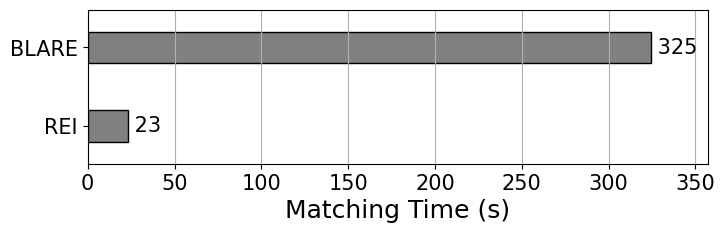

In [11]:
df_best = pd.DataFrame([['REI', min_time], ['BLARE', blare_mean]], columns=['Name', 'Time'])
colors = sns.color_palette('colorblind', 2)  

fig, ax = plt.subplots(figsize=(8, 2))

x = np.arange(len(colors))  # the label locations
plt.grid(axis='x')

ax.barh(df_best['Name'], df_best['Time'], height=0.4, color='grey', edgecolor='black')#, label=gram)

ax.bar_label(ax.containers[-1], fmt=' %.0f')
print([p.get_width() for p in ax.patches])

maxy = 1.1*np.max([blare_mean, min_time])
plt.xlim(0, maxy)
ax.set_ymargin(0.2)
ax.set_ylabel('')
ax.set_xlabel(f'Matching Time (s)')

plt.savefig('figs/best_result.pdf', bbox_inches = 'tight')

plt.show()

['#0173b2', '#de8f05']
[13.5, 13.5, 0.28463999999999956, 0.0]


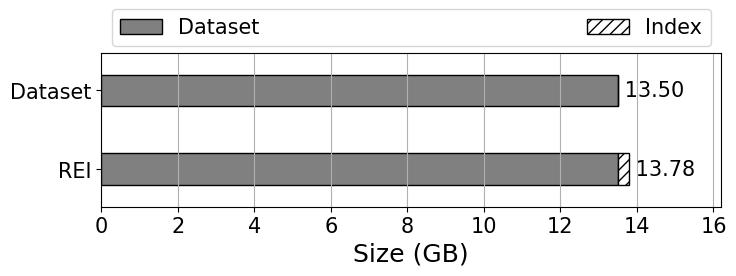

In [12]:
df_data_size = pd.DataFrame([['REI', 13.5], ['Dataset', 13.5]], columns=['Name', 'Size(GB)'])
df_index_size = pd.DataFrame([['REI', 0.28464], ['Dataset', 0]], columns=['Name', 'Size(GB)'])

colors = sns.color_palette('colorblind', 2)  

fig, ax = plt.subplots(figsize=(8,2))

x = np.arange(len(colors))  # the label locations
plt.grid(axis='x')

ax.barh(df_data_size['Name'], df_data_size['Size(GB)'], height=0.4, color='grey', edgecolor='black')#, label=gram)
ax.barh(df_index_size['Name'], df_index_size['Size(GB)'], left=df_data_size['Size(GB)'], height=0.4, color='white', hatch='///', edgecolor='black')#, label=gram)

ax.bar_label(ax.containers[-1], fmt=' %.2f')
print([p.get_width() for p in ax.patches])

maxy = 1.2*np.max(df_data_size['Size(GB)'])
plt.xlim(0, maxy)
ax.set_ymargin(0.2)
ax.set_ylabel('')
ax.set_xlabel(f'Size (GB)')

plt.legend(['Dataset', 'Index'], loc='upper left', bbox_to_anchor=(0, 1.35, 1, 0), ncol=2, mode='expand')
plt.savefig('figs/best_result_size.pdf', bbox_inches = 'tight')

plt.show()

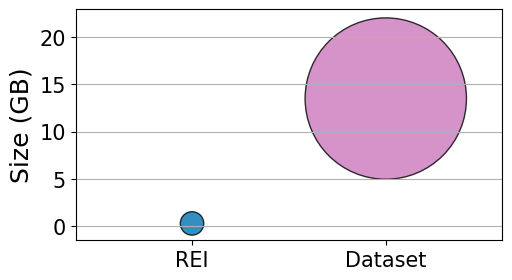

In [13]:
df_best_size = pd.DataFrame([['REI', 0.28464], ['Dataset', 13.5]], columns=['Name', 'Size(GB)'])
colors = sns.color_palette('colorblind', 5)  
colors = [colors[0], colors[-1]]
fig, ax = plt.subplots(figsize=(5.5,3))
x = np.arange(len(colors))  # the label locations
plt.grid(axis='y')

ax.scatter(df_best_size['Name'], df_best_size['Size(GB)'], s=df_best_size['Size(GB)']*1000, color=colors, edgecolor='black', alpha=0.8)#, label=gram)

maxy = 1.7*np.max(df_best_size['Size(GB)'])
plt.ylim(-1.5, maxy)

ax.set_xlabel('')
ax.set_ylabel(f'Size (GB)')
ax.set_xmargin(0.6)

plt.savefig('figs/best_result_size_dot.pdf', bbox_inches = 'tight')

plt.show()

In [21]:
def plot_bar_with_err2(df, plot_dict, color_map, edge_color, fname_prefix, log_scale=False, baseline=False):
    fig, ax = plt.subplots(figsize=plot_dict['figsize'])
    plt.grid(axis='y')

    x = np.arange(len(GRANUS))  # the label locations

    gram = 'Bigram Index'
    
    if baseline:
        y_est = [blare_mean] * len(x)
        y_err = [blare_se] * len(x)    
        width = df.shape[0]  # the width of the bars
        rects = ax.bar([x[0]+0.42*width], [blare_mean], width+0.5 , color='gray', label='BLARE-RE2', alpha=0.2)

    width = 0.80
    
    color = []
    rects = ax.bar(x, df[plot_dict['col_y1']], width, yerr=None if plot_dict['col_err1'] is None else df[plot_dict['col_err1']], color=color_map[0], edgecolor=edge_color, label='BitVector Index')

    ax.set_xticks(x, GRANUS)

    if baseline:
        for c in ax.containers[0::2]:
            ax.bar_label(c, fmt='%.0f')
    else:
        for c in ax.containers:#[0::2]:
            if 'Size' in plot_dict['title']:
                ax.bar_label(c, fmt='%.2f')
            else:
                ax.bar_label(c, fmt='%.0f')
    
    maxy = np.max([np.max(df[plot_dict['col_y1']].to_list())])
    miny = np.min([np.min(df[plot_dict['col_y1']].to_list())])
    if baseline:
        maxy = np.max([blare_mean,maxy])
    maxy = 1.1*maxy
    miny = 0.8*miny
    if log_scale:
        plt.yscale('log')
        plt.ylim( (pow(10,np.log10(miny)),pow(10,np.log10(maxy))) )
    else:
        plt.ylim(0, maxy)
    
    plt.xlabel(f'number of Log lines For Each Bitset')
    plt.ylabel(plot_dict['ylabel'])

    if baseline:
        plt.legend(loc='center left', bbox_to_anchor=(0, 0.7))
    log_scale_tag = '' if not log_scale else '_log'

    plt.savefig(f'figs/Only_Index{TARGET_INDEX_NUM}_{fname_prefix}_errbar_{log_scale_tag}.pdf', bbox_inches = 'tight')

    plt.show()

In [22]:
TARGET_INDEX_NUM = 128

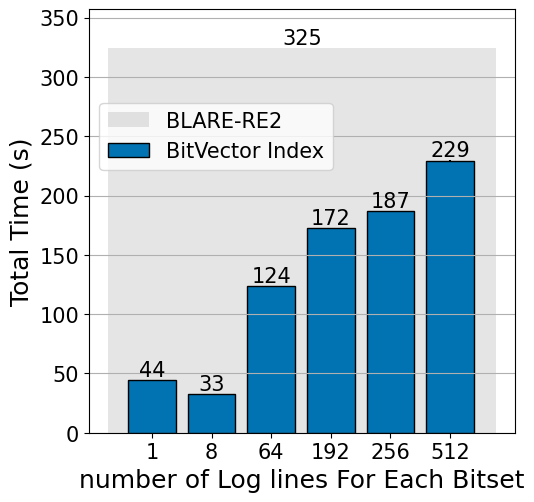

In [23]:
plot_dict= {
    'col_y1': 'Bitvec_Time_Mean(s)',
    'col_err1': 'Bitvec_Time_SE(s)',
    'ylabel': 'Total Time (s)',
    'title': f'{TARGET_INDEX_NUM} Bigram Filter Runtime',
    'figsize': (5.5,5.5)
}
df = overall_df[overall_df['Num_Indexed'] == TARGET_INDEX_NUM]
colors = ['#0173b2', '#66c2a5']
plot_bar_with_err2(df, plot_dict, colors, 'black', fname_prefix='SearchTime', log_scale=False, baseline=True)

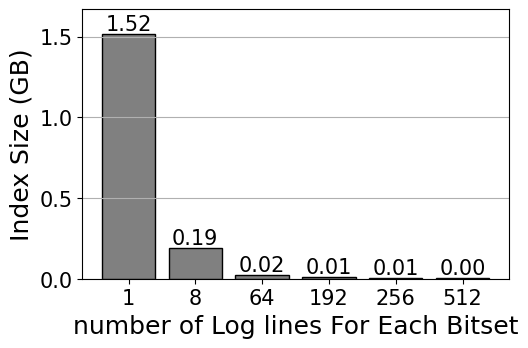

In [25]:
plot_dict= {
    'col_y1': 'Bit_Index_Size(GB)',
    'col_err1': None, #'Bit_Index_Building_Time_SE(s)',
    'ylabel': 'Index Size (GB)',
    'title': f'{TARGET_INDEX_NUM} Bigram Index Size',
    'figsize': (5.5,3.5)
}
df = overall_df[overall_df['Num_Indexed'] == TARGET_INDEX_NUM]

colors = ['#e7298a', '#66a61e'] 
plot_bar_with_err2(df, plot_dict, ['grey'], 'black', fname_prefix='IndexSize', log_scale=False, baseline=False)

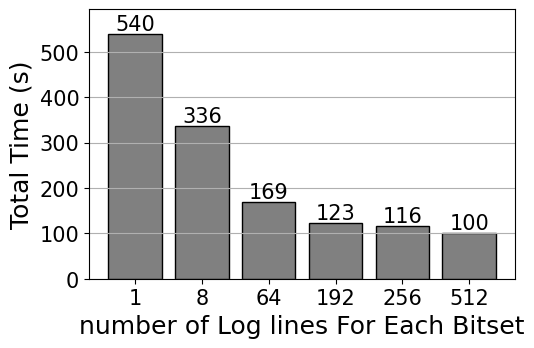

In [26]:
plot_dict= {
    'col_y1': 'Bit_Index_Building_Time_Mean(s)',
    'col_err1': None, #'Bit_Index_Building_Time_SE(s)',
    'ylabel': 'Total Time (s)',
    'title': f'{TARGET_INDEX_NUM} Bigram Index Building Time',
    'figsize': (5.5,3.5)
}
df = overall_df[overall_df['Num_Indexed'] == TARGET_INDEX_NUM]
colors = ['#d55e00', '#1b9e77'] 
plot_bar_with_err2(df, plot_dict, ['grey'], 'black', fname_prefix='IndexBuilding', log_scale=False, baseline=False)

In [27]:
def plot_bar_with_err2(df, plot_dict, color_map, edge_color, fname_prefix, log_scale=False, baseline=False):
    fig, ax = plt.subplots(figsize=plot_dict['figsize'])
    plt.grid(axis='y')

    x = np.arange(len(GRANUS))  # the label locations

    gram = 'Bigram Index'
    
    if baseline:
        y_est = [blare_mean] * len(x)
        y_err = [blare_se] * len(x)    
        width = df.shape[0]  # the width of the bars
        rects = ax.bar([x[0]+0.42*width], [blare_mean], width+0.5 , color='gray', label='BLARE-RE2', alpha=0.2)

    width = 0.80
    
    color = []
    rects = ax.bar(x, df[plot_dict['col_y1']], width, yerr=None if plot_dict['col_err1'] is None else df[plot_dict['col_err1']], color=color_map[0], edgecolor=edge_color, label='BitVector Index')

    ax.set_xticks(x, GRANUS)

    if baseline:
        for c in ax.containers[0::2]:
            ax.bar_label(c, fmt='%.0f')
    else:
        for c in ax.containers:#[0::2]:
            if 'Size' in plot_dict['title']:
                ax.bar_label(c, fmt='%.2f')
            else:
                ax.bar_label(c, fmt='%.0f')

    maxy = np.max([np.max(df[plot_dict['col_y1']].to_list())])
    miny = np.min([np.min(df[plot_dict['col_y1']].to_list())])
    if baseline:
        maxy = np.max([blare_mean,maxy])
    maxy = 1.2*maxy
    miny = 0.8*miny
    if log_scale:
        plt.yscale('log')
        plt.ylim( (pow(10,np.log10(miny)),pow(10,np.log10(maxy))) )
    else:
        plt.ylim(0, maxy)
    
    plt.xlabel(f'number of Log lines For Each Bitset')
    plt.ylabel(plot_dict['ylabel'])
    if baseline:
        plt.legend(loc='best')#, bbox_to_anchor=(0, 0.6))
    log_scale_tag = '' if not log_scale else '_log'
    print(f'figs/Only_Index{TARGET_INDEX_NUM}_{fname_prefix}_errbar_{log_scale_tag}.pdf')
    plt.savefig(f'figs/Only_Index{TARGET_INDEX_NUM}_{fname_prefix}_errbar_{log_scale_tag}.pdf', bbox_inches = 'tight')

    plt.show()

In [28]:
TARGET_INDEX_NUM = 64

figs/Only_Index64_SearchTime_errbar_.pdf


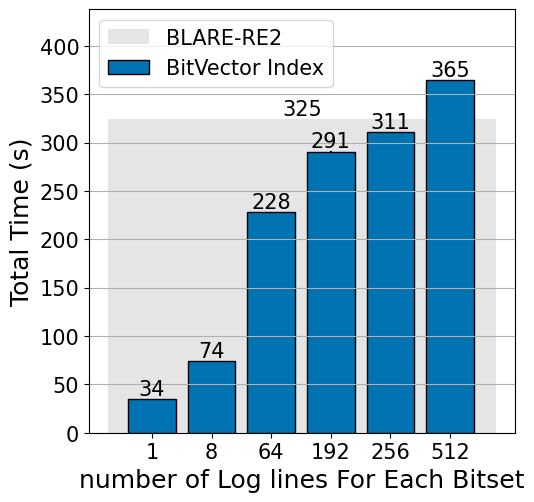

In [29]:
plot_dict= {
    'col_y1': 'Bitvec_Time_Mean(s)',
    'col_err1': 'Bitvec_Time_SE(s)',
    'ylabel': 'Total Time (s)',
    'title': f'{TARGET_INDEX_NUM} Bigram Filter Runtime',
    'figsize': (5.5,5.5)
}
df = overall_df[overall_df['Num_Indexed'] == TARGET_INDEX_NUM]
colors = ['#0173b2', '#66c2a5']
plot_bar_with_err2(df, plot_dict, colors, 'black', fname_prefix='SearchTime', log_scale=False, baseline=True)

figs/Only_Index64_IndexSize_errbar_.pdf


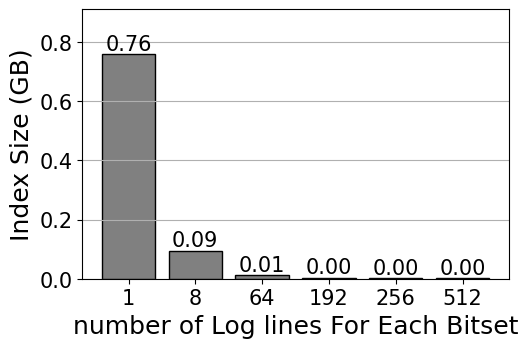

In [31]:
plot_dict= {
    'col_y1': 'Bit_Index_Size(GB)',
    'col_err1': None, #'Bit_Index_Building_Time_SE(s)',
    'ylabel': 'Index Size (GB)',
    'title': f'{TARGET_INDEX_NUM} Bigram Index Size',
    'figsize': (5.5,3.5)
}
df = overall_df[overall_df['Num_Indexed'] == TARGET_INDEX_NUM]

plot_bar_with_err2(df, plot_dict, ['grey'], 'black', fname_prefix='IndexSize', log_scale=False, baseline=False)

figs/Only_Index64_IndexBuilding_errbar_.pdf


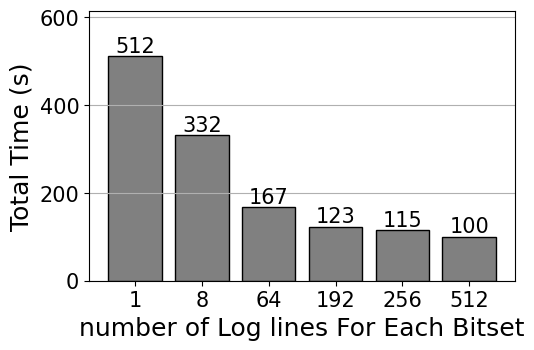

In [32]:
plot_dict= {
    'col_y1': 'Bit_Index_Building_Time_Mean(s)',
    'col_err1': None, #'Bit_Index_Building_Time_SE(s)',
    'ylabel': 'Total Time (s)',
    'title': f'{TARGET_INDEX_NUM} Bigram Index Building Time',
    'figsize': (5.5,3.5)
}
df = overall_df[overall_df['Num_Indexed'] == TARGET_INDEX_NUM]
plot_bar_with_err2(df, plot_dict, ['grey'], 'black', fname_prefix='IndexBuilding', log_scale=False, baseline=False)